In [18]:
import pandas as pd
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
import joblib

In [19]:
# Function to load CSV files from a directory and assign labels
def load_csvs_from_folder(folder_path, label):
    csv_files = glob(os.path.join(folder_path, '*.csv'))
    dataframes = []
    for file in csv_files:
        df = pd.read_csv(file)
        df['Class'] = label  # Assign class label (0 for animal, 1 for plant)
        dataframes.append(df)
    return pd.concat(dataframes, ignore_index=True)

In [20]:
# Load data from two directories
animal_oils_folder = 'processed_data/Animal'
plant_oils_folder = 'processed_data/Plant'

In [21]:
# Load data for both classes
animal_oils_data = load_csvs_from_folder(animal_oils_folder, label=0)
plant_oils_data = load_csvs_from_folder(plant_oils_folder, label=1)

In [22]:
# Combine both datasets into a single DataFrame
df = pd.concat([animal_oils_data, plant_oils_data], ignore_index=True)

In [23]:
# Check the structure of the combined data
print(df.head())
print(df['Class'].value_counts())

        MQ2       MQ3      MQ4       MQ5       MQ6       MQ7       MQ8  \
0 -0.550251 -4.106784 -0.69598 -0.030151 -1.079146  2.332915  0.877513   
1  0.449749 -4.106784 -0.69598 -0.030151 -0.079146  2.332915  1.877513   
2 -0.550251 -4.106784  0.30402 -0.030151 -0.079146  2.332915  1.877513   
3 -0.550251 -5.106784  0.30402 -0.030151 -1.079146  1.332915 -0.122487   
4 -0.550251 -5.106784 -0.69598 -0.030151 -0.079146  1.332915 -0.122487   

        MQ9     MQ135     MQ137  Class  
0  2.719221 -0.912688  0.689698      0  
1  1.719221  1.087312  1.689698      0  
2  1.719221  0.087312  1.689698      0  
3  1.719221  0.087312  1.689698      0  
4  1.719221 -0.912688  1.689698      0  
Class
0    196175
1    190411
Name: count, dtype: int64


In [28]:
# Split features (X) and target (y)
X = df.drop(columns='Class')
y = df['Class']

In [29]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=32)

In [30]:
# More preprocessing measures
print(X_train.head())  # Quick view of the data
print(X_train.info())  # Check data types
print(X_train.isnull().sum())  # Check for null values

             MQ2        MQ3       MQ4       MQ5       MQ6       MQ7  \
184087 -1.433622  27.909940  0.197465 -0.503002  3.538359  2.178786   
367054  1.424400  23.078206  0.203337  0.475495 -9.290928 -5.577685   
185094 -1.433622  45.909940  1.197465  0.496998  2.538359  2.178786   
26412   3.406810  19.839904  3.584229  2.384707  7.147551  7.970729   
58065   0.552357  48.810597  1.186483  1.370046  2.880267  0.653734   

              MQ8        MQ9     MQ135      MQ137  
184087   7.436958   3.551701  0.149433  12.861241  
367054   0.772680  -3.397289  0.974974  17.217935  
185094  11.436958   5.551701  1.149433  28.861241  
26412    7.796296  12.856033  1.930108  15.821983  
58065    9.012933   5.858573  0.170630  32.776387  
<class 'pandas.core.frame.DataFrame'>
Index: 309268 entries, 184087 to 197719
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   MQ2     309268 non-null  float64
 1   MQ3     309268 non-null  float6

In [31]:
# Checking for non-numeric data
invalid_rows = X_train.map(lambda x: isinstance(x, str) and not x.isnumeric())
print(X_train[invalid_rows.any(axis=1)])  # Show rows with non-numeric data

Empty DataFrame
Columns: [MQ2, MQ3, MQ4, MQ5, MQ6, MQ7, MQ8, MQ9, MQ135, MQ137]
Index: []


In [32]:
# Data cleaning (as needed)


# Replace invalid entries with NaN
# X_train = X_train.replace({r'[^\d.]': np.nan}, regex=True)

# Convert the column to numeric, coercing errors to NaN
# X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN (optional, depending on your handling strategy)
# X_train = X_train.dropna()

In [33]:
# Define the pipeline with StandardScaler, PCA, and XGBClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),  # Principal Component Analysis
    ('clf', XGBClassifier(random_state=32, eval_metric='logloss'))  # XGBoost Classifier
])

In [155]:
# To handle unformatted values
X_train = X_train.map(lambda x: x.replace('\x18', '') if isinstance(x, str) else x)
X_test = X_test.map(lambda x: x.replace('\x18', '') if isinstance(x, str) else x)

In [35]:
# Define the search space for Bayesian optimization
search_space = {
    'clf__max_depth': Integer(2, 8),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0),
    'pca__n_components': Integer(2, min(X_train.shape[1],9))
}

# Use BayesSearchCV for hyperparameter optimization
opt = BayesSearchCV(pipeline, search_space, cv=5, n_iter=12, scoring='roc_auc', random_state=32)
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('pca', PCA()),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric='logloss',
                                                       feature_types=None,
                                                       gamma=None,
                                                       grow_policy=Non...
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize'),
                             'pca__n_components': Integer(low=2, high=9, prior='uniform', transform='normalize')})

In [36]:
# Best model and its performance
print("Best Estimator:", opt.best_estimator_)
print("Best Score on Training Data:", opt.best_score_)
print("Score on Test Data:", opt.score(X_test, y_test))

Best Estimator: Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=8)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=0.5000231227686287,
                               colsample_bynode=0.825713608829179,
                               colsample_bytree=0.5, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=1.2576893...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.3054181882864081, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leave

In [37]:
# Predictions and probabilities
y_pred = opt.predict(X_test)
y_proba = opt.predict_proba(X_test)

In [38]:
# Evaluate accuracy and log loss
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {logloss}")

Test Accuracy: 0.9790217025789596
Test Log Loss: 0.05554452854107102


In [39]:
# Save the best estimator
model_save_path = 'models/dec30_xgboost_oil_classifier_model.joblib'
joblib.dump(opt.best_estimator_, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/dec30_xgboost_oil_classifier_model.joblib


In [40]:
# Save the PCA transformer separately
# pca_save_path = 'models/new_pca_transformer.joblib'
# best_pca = opt.best_estimator_.named_steps['pca']
# joblib.dump(best_pca, pca_save_path)
# print(f"PCA transformer saved to {pca_save_path}")

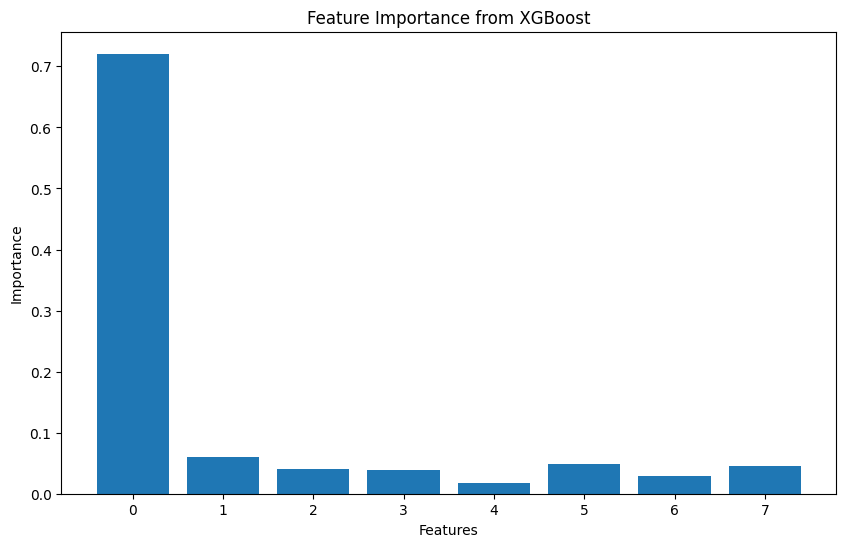

In [41]:
# Feature importance from XGBoost
feature_importance = opt.best_estimator_.named_steps['clf'].feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Feature Importance from XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [42]:
# PCA Visualization
pca = opt.best_estimator_.named_steps['pca']
#X_train_pca = pca.transform(X_train)
#X_test_pca = pca.transform(X_test)
X_train_pca = best_pca.transform(X_train)
X_test_pca = best_pca.transform(X_test)


NameError: name 'best_pca' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', alpha=0.5, label='Training')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='coolwarm', marker='x', alpha=0.8, label='Testing')
plt.title('PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()